# Mod 3 Final Project

## Student Info

- Name: Susanna Han
- Cohort: Part Time
- Instructor: James


## Introduction

Statistically analyzing the NorthWind SQL query. First, use the database below to create 4 hypotheses to help inform and give directive recommendations to the company. Then pull and organize the information needed to test the different hypotheses. Run different tests through the grouped data to reject or accept the assumptions to confirm your findings.

The different tests that are used in this project are D'Agostino-Pearson's, Levene's, Kruskal-Wallis, Statistical Power, and Tukey's Pairwise.

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-mod-3-project-online-ds-ft-100719/master/Northwind_ERD_updated.png">

# PROJECT

In [1]:
!pip install -U fsds_100719
from fsds_100719.imports import *
import pandas as pd

fsds_1007219  v0.7.16 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [2]:
import pandas as pd
import scipy.stats as stats
import pandas as pd
import numpy as np
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def Cohen_d(group1, group2, correction = False):
    """Compute Cohen's d
    d = (group1.mean()-group2.mean())/pool_variance.
    pooled_variance= (n1 * var1 + n2 * var2) / (n1 + n2)

    Args:
        group1 (Series or NumPy array): group 1 for calculating d
        group2 (Series or NumPy array): group 2 for calculating d
        correction (bool): Apply equation correction if N<50. Default is False. 
            - Url with small ncorrection equation: 
                - https://www.statisticshowto.datasciencecentral.com/cohens-d/ 
    Returns:
        d (float): calculated d value
         
    INTERPRETATION OF COHEN's D: 
    > Small effect = 0.2
    > Medium Effect = 0.5
    > Large Effect = 0.8
    
    """
    import scipy.stats as stats
    import scipy   
    import numpy as np
    N = len(group1)+len(group2)
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    ## Apply correction if needed
    if (N < 50) & (correction==True):
        d=d * ((N-3)/(N-2.25))*np.sqrt((N-2)/N)
    return d


#Your code here
def find_outliers_z(data):
    """Use scipy to calculate absolute Z-scores 
    and return boolean series where True indicates it is an outlier.

    Args:
        data (Series,or ndarray): data to test for outliers.

    Returns:
        [boolean Series]: A True/False for each row use to slice outliers.
        
    EXAMPLE USE: 
    >> idx_outs = find_outliers_df(df['AdjustedCompensation'])
    >> good_data = df[~idx_outs].copy()
    """
    import pandas as pd
    import numpy as np
    import scipy.stats as stats
    import pandas as pd
    import numpy as np
    ## Calculate z-scores
    zs = stats.zscore(data)
    
    ## Find z-scores >3 awayfrom mean
    idx_outs = np.abs(zs)>3
    
    ## If input was a series, make idx_outs index match
    if isinstance(data,pd.Series):
        return pd.Series(idx_outs,index=data.index)
    else:
        return pd.Series(idx_outs)
    
    
    
def find_outliers_IQR(data):
    """Use Tukey's Method of outlier removal AKA InterQuartile-Range Rule
    and return boolean series where True indicates it is an outlier.
    - Calculates the range between the 75% and 25% quartiles
    - Outliers fall outside upper and lower limits, using a treshold of  1.5*IQR the 75% and 25% quartiles.

    IQR Range Calculation:    
        res = df.describe()
        IQR = res['75%'] -  res['25%']
        lower_limit = res['25%'] - 1.5*IQR
        upper_limit = res['75%'] + 1.5*IQR

    Args:
        data (Series,or ndarray): data to test for outliers.

    Returns:
        [boolean Series]: A True/False for each row use to slice outliers.
        
    EXAMPLE USE: 
    >> idx_outs = find_outliers_df(df['AdjustedCompensation'])
    >> good_data = df[~idx_outs].copy()
    
    """
    df_b=data
    res= df_b.describe()

    IQR = res['75%'] -  res['25%']
    lower_limit = res['25%'] - 1.5*IQR
    upper_limit = res['75%'] + 1.5*IQR

    idx_outs = (df_b>upper_limit) | (df_b<lower_limit)

    return idx_outs



def prep_data_for_tukeys(data):
    """Accepts a dictionary with group names as the keys 
    and pandas series as the values. 
    
    Returns a dataframe ready for tukeys test:
    - with a 'data' column and a 'group' column for sms.stats.multicomp.pairwise_tukeyhsd 
    
    Example Use:
    df_tukey = prep_data_for_tukeys(grp_data)
    tukey = sms.stats.multicomp.pairwise_tukeyhsd(df_tukey['data'], df_tukey['group'])
    tukey.summary()
    """
    
    df_tukey = pd.DataFrame(columns=['data','group'])
    for k,v in  data.items():
        grp_df = v.rename('data').to_frame() 
        grp_df['group'] = k
        df_tukey=pd.concat([df_tukey, grp_df],axis=0)

	## New lines added to ensure compatibility with tukey's test
    df_tukey['group'] = df_tukey['group'].astype('str')
    df_tukey['data'] = df_tukey['data'].astype('float')
    return df_tukey


In [5]:
import sqlite3
connect = sqlite3.connect('Northwind_small.sqlite')
cur = connect.cursor()

In [6]:
## To see all tables
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


# Hypothesis 1

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

- $H_0$: The customer orders the same quantity of a product whether it's discounted or full price. 
- $H_A$: The customer orders more or less of a product whether it's discounted or full price.

First explore the data and pull in the information needed to test the hypothesis. A discount group column was created to translate the bool into words to define the content in a more clear way. (Discounted or Full Price) This helps for future references without remembering which was True and False. After gathering the information you will be using a bar graph to have a general visual of the dataset pulled. 

In [7]:
cur.execute('''SELECT * from OrderDetail''')
col_names = [x[0] for x in cur.description]
col_names

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [8]:
df = pd.DataFrame(cur.fetchall(), columns = col_names)
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [9]:
df['Discount_grp'] = df['Discount'] > 0
df['Discount_grp'] = df['Discount_grp'].map({True:'Discounted', False: 'Full Price'})
df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discount_grp
0,10248/11,10248,11,14.00,12,0.00,Full Price
1,10248/42,10248,42,9.80,10,0.00,Full Price
2,10248/72,10248,72,34.80,5,0.00,Full Price
3,10249/14,10249,14,18.60,9,0.00,Full Price
4,10249/51,10249,51,42.40,40,0.00,Full Price
5,10250/41,10250,41,7.70,10,0.00,Full Price
6,10250/51,10250,51,42.40,35,0.15,Discounted
7,10250/65,10250,65,16.80,15,0.15,Discounted
8,10251/22,10251,22,16.80,6,0.05,Discounted
9,10251/57,10251,57,15.60,15,0.05,Discounted


A bar graph was created comparing the different discount amounts with the number of products bought to see a general comparison. 

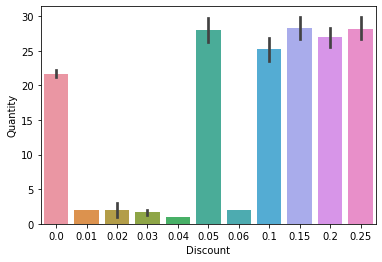

In [10]:
sns.barplot(data=df, x = df['Discount'], y= df['Quantity'], ci=68);

The quantity of products are then grouped into the same discount categories as seen above. Then a subplot is made with the multiple discounted groups to show a general distribution of the number of products sold at a certain discount percentage. (Shown Below)

In [11]:
discounts = {}
for discount_grps in df['Discount'].unique():
    discounts[discount_grps]= df.groupby('Discount').get_group(discount_grps)['Quantity']
discounts

{0.0: 0        12
 1        10
 2         5
 3         9
 4        40
 5        10
 10       20
 13       40
 14       20
 15       42
 16       40
 19       21
 20       20
 21       35
 22       25
 23       30
 24       15
 25       12
 26       25
 27        6
 28       15
 32       10
 33        1
 35       50
 38       20
 39       20
 41       15
 42        2
 44       28
 47       35
        ... 
 2088      4
 2089     10
 2090     15
 2093     30
 2097     12
 2100     55
 2103      3
 2104     42
 2105     35
 2106      9
 2110     20
 2114     20
 2117      8
 2118     40
 2119     22
 2120    130
 2121     10
 2122     20
 2131      4
 2132      1
 2136      1
 2138      4
 2142      2
 2143      1
 2145      3
 2147      2
 2148      2
 2151      1
 2153      4
 2154      2
 Name: Quantity, Length: 1317, dtype: int64, 0.15: 6       35
 7       15
 17      15
 18      21
 48      25
 53      70
 54      15
 104     40
 106     15
 196     21
 197     70
 199     40
 200    

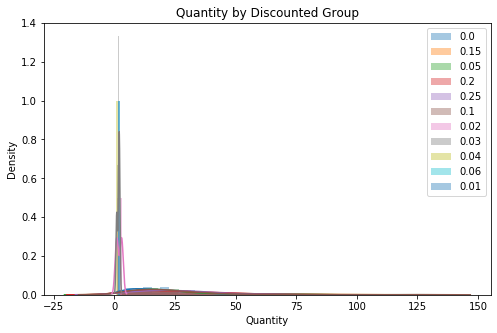

In [12]:
fig, ax=plt.subplots(figsize = (8,5))
for discount_grps, grp_data in discounts.items():
    sns.distplot(grp_data, label=discount_grps, ax=ax)
ax.legend()
ax.set(title ='Quantity by Discounted Group', ylabel = 'Density');

The idx_outs function is used to find and delete outliers using z-scores. Another subplot graph is then created to see the difference once the outliers found are gone. We can see a slightly more normal distribution in the graph below.

In [13]:
for discount_grps, grp_data in discounts.items():
    idx_outs = find_outliers_z(grp_data)
    print(f'I found {idx_outs.sum()} outliers in {discount_grps} using z-scores')
    discounts[discount_grps] = grp_data[-idx_outs]

I found 20 outliers in 0.0 using z-scores
I found 2 outliers in 0.15 using z-scores
I found 3 outliers in 0.05 using z-scores
I found 2 outliers in 0.2 using z-scores
I found 3 outliers in 0.25 using z-scores
I found 3 outliers in 0.1 using z-scores
I found 0 outliers in 0.02 using z-scores
I found 0 outliers in 0.03 using z-scores
I found 0 outliers in 0.04 using z-scores
I found 0 outliers in 0.06 using z-scores
I found 0 outliers in 0.01 using z-scores


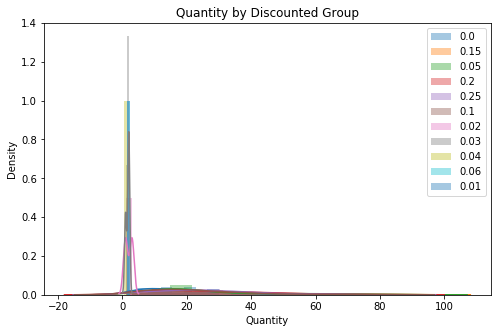

In [14]:
fig, ax=plt.subplots(figsize = (8,5))
for discount_grps, grp_data in discounts.items():
    sns.distplot(grp_data, label=discount_grps, ax=ax )
ax.legend()
ax.set(title ='Quantity by Discounted Group', ylabel = 'Density');

The discount percentages that do not have enough data are then taken out of the dataset using a for loop to find the small categories. The other discount categories with more than 8 data points are then shown with a p-value < 0.05 Therefore the data is not normal but because the size of the data. The results of the normal test is ignored. Therefore, moving on to test the equal variance using the levene's test. The results are shown below.

In [15]:
for k,v in discounts.items():
    if len(v) > 8: 
        stat,p = stats.normaltest(v)
        print(f"The {k} Normaltest p-value = {round(p,4)}")
    else: 
        print(f"The column {k} is too small.")

The 0.0 Normaltest p-value = 0.0
The 0.15 Normaltest p-value = 0.0
The 0.05 Normaltest p-value = 0.0
The 0.2 Normaltest p-value = 0.0005
The 0.25 Normaltest p-value = 0.0013
The 0.1 Normaltest p-value = 0.0
The column 0.02 is too small.
The column 0.03 is too small.
The column 0.04 is too small.
The column 0.06 is too small.
The column 0.01 is too small.


In [16]:
toosmall = (0.02, 0.03, 0.04, 0.06, 0.01)
for key in toosmall:
    discounts.pop(key)

In [17]:
for k,v in discounts.items():
    print(f"There are {len(v)} in group {k}.")

There are 1297 in group 0.0.
There are 155 in group 0.15.
There are 182 in group 0.05.
There are 159 in group 0.2.
There are 151 in group 0.25.
There are 170 in group 0.1.


In [18]:
data = []
for k,v in discounts.items():
    data.append(v)
data[0]

0       12
1       10
2        5
3        9
4       40
5       10
10      20
13      40
14      20
15      42
16      40
19      21
20      20
21      35
22      25
23      30
24      15
25      12
26      25
27       6
28      15
32      10
33       1
35      50
38      20
39      20
41      15
42       2
44      28
47      35
        ..
2087    35
2088     4
2089    10
2090    15
2093    30
2097    12
2100    55
2103     3
2104    42
2105    35
2106     9
2110    20
2114    20
2117     8
2118    40
2119    22
2121    10
2122    20
2131     4
2132     1
2136     1
2138     4
2142     2
2143     1
2145     3
2147     2
2148     2
2151     1
2153     4
2154     2
Name: Quantity, Length: 1297, dtype: int64

In [19]:
stat,p = stats.levene(*data) 
print(f"Levene's test for equal variance p-value ={round(p,4)} therefore it does not have equal variance.")

Levene's test for equal variance p-value =0.0003 therefore it does not have equal variance.


To test the hypothesis the Kruskal-Wallis method is used to calculate the p-value. Results shown below.

In [20]:
stat,p = stats.kruskal(*data)
print(f'Kruskal-Wallis t-test p-value ={round(p,4)} therefore the alternative hypothesis is statistically significance.')

Kruskal-Wallis t-test p-value =0.0 therefore the alternative hypothesis is statistically significance.


With multiple different discount percentages a tukey's test is done to see which groups are significantly different between the amount of items sold correlated with at which the discount was given. A matrix table was then created comparing each group with another showing the mean difference.

In [21]:
df_tukeys = prep_data_for_tukeys(discounts)
df_tukeys.head()
df_tukeys.columns = ['Quantity','Discount']

In [22]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
model= pairwise_tukeyhsd(df_tukeys['Quantity'],df_tukeys['Discount'])
model.summary()
df = pd.DataFrame(data=model._results_table.data[1:], columns=model._results_table.data[0])
df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.0,0.05,6.0639,0.0010,2.4368,9.6910,True
1,0.0,0.1,2.9654,0.2098,-0.7723,6.7031,False
2,0.0,0.15,6.9176,0.0010,3.0233,10.8119,True
3,0.0,0.2,5.6293,0.0010,1.7791,9.4796,True
4,0.0,0.25,6.1416,0.0010,2.2016,10.0817,True
5,0.05,0.1,-3.0985,0.4621,-7.9861,1.7890,False
6,0.05,0.15,0.8537,0.9000,-4.1547,5.8620,False
7,0.05,0.2,-0.4346,0.9000,-5.4088,4.5396,False
8,0.05,0.25,0.0777,0.9000,-4.9663,5.1218,False
9,0.1,0.15,3.9522,0.2311,-1.1368,9.0412,False


Then the statistically significant columns are pulled into a seperate table with it's own p-value.

In [23]:
sig = df.loc[df['reject']==True][['group1', 'group2', 'p-adj']]
sig.columns = ['discount1','discount2','p-value']
sig

,discount1,discount2,p-value
0,0.0,0.05,0.001
2,0.0,0.15,0.001
3,0.0,0.2,0.001
4,0.0,0.25,0.001


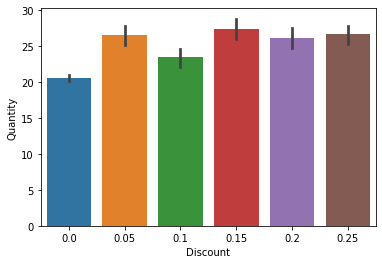

In [24]:
sns.barplot(data=df, x = df_tukeys['Discount'], y= df_tukeys['Quantity'], ci=68);

As shown in the bar graph above it is statistically significant that the customers order more of a product when it is discounted than when it is at full price. Whether it is 5%, 15%, 20%, or 25% it will increase the quantity of products sold in an order.

# Hypothesis 2

> Does discount have a statistically significant effect on the total amount spent in an order? 

- $H_0$: The customer spends the same amount of money whether it's discounted or full price. 
- $H_A$: The customer spends more or less money whether it's discounted or full price.

Explore the data and pull in the information needed to test the hypothesis. Another column was created to show the total amount spent. To find the total amount spent on an order we multiply the unit price by the number of items bought. After gathering the information a bar graph is made to have a general visual of the dataset pulled. 

In [25]:
cur.execute('''SELECT * from OrderDetail''')
col_names = [x[0] for x in cur.description]
col_names

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [26]:
df = pd.DataFrame(cur.fetchall(), columns = col_names)
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [27]:
df['Total Spent'] = df['UnitPrice'] * df['Quantity']
df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Total Spent
0,10248/11,10248,11,14.00,12,0.00,168.00
1,10248/42,10248,42,9.80,10,0.00,98.00
2,10248/72,10248,72,34.80,5,0.00,174.00
3,10249/14,10249,14,18.60,9,0.00,167.40
4,10249/51,10249,51,42.40,40,0.00,1696.00
5,10250/41,10250,41,7.70,10,0.00,77.00
6,10250/51,10250,51,42.40,35,0.15,1484.00
7,10250/65,10250,65,16.80,15,0.15,252.00
8,10251/22,10251,22,16.80,6,0.05,100.80
9,10251/57,10251,57,15.60,15,0.05,234.00


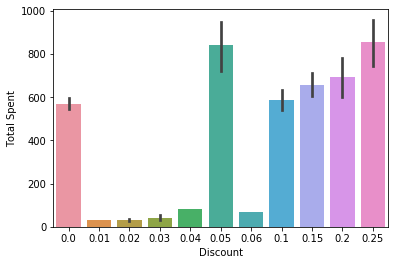

In [28]:
sns.barplot(data=df, x = df['Discount'], y= df['Total Spent'], ci=68);

Then a discount dictionary is created to group all the discount categories with the total spent to create a subplot showing the distribution. (Shown below)

In [29]:
discounts = {}
for discount_grps in df['Discount'].unique():
    discounts[discount_grps]= df.groupby('Discount').get_group(discount_grps)['Total Spent']
discounts

{0.0: 0        168.00
 1         98.00
 2        174.00
 3        167.40
 4       1696.00
 5         77.00
 10       336.00
 13      1088.00
 14       200.00
 15       604.80
 16       640.00
 19       168.00
 20       304.00
 21       486.50
 22       380.00
 23      1320.00
 24       393.00
 25       124.80
 26       877.50
 27        86.40
 28       156.00
 32        80.00
 33        20.80
 35       780.00
 38       160.00
 39       288.00
 41       360.00
 42        60.80
 44       100.80
 47       532.00
          ...   
 2088     136.00
 2089     130.00
 2090     510.00
 2093     420.00
 2097     115.80
 2100     687.50
 2103      52.35
 2104     386.40
 2105     490.00
 2106      86.85
 2110     360.00
 2114     250.00
 2117     152.00
 2118     386.00
 2119     357.50
 2120    4322.50
 2121     210.00
 2122      90.00
 2131      40.00
 2132      22.00
 2136      31.00
 2138      24.00
 2142      18.00
 2143      32.00
 2145      28.95
 2147      14.00
 2148      48.00
 2151    

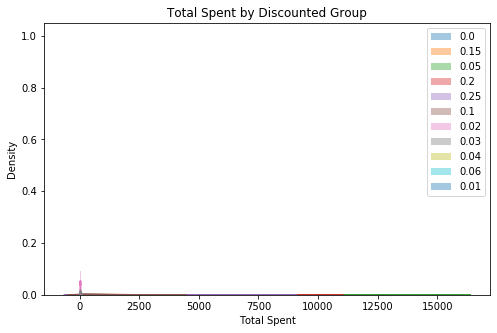

In [30]:
fig, ax=plt.subplots(figsize = (8,5))
for discount_grps, grp_data in discounts.items():
    sns.distplot(grp_data, label=discount_grps, ax=ax )
ax.legend()
ax.set(title ='Total Spent by Discounted Group', ylabel = 'Density');

The idx_outs function is used to find and delete outliers using z-scores. Another subplot graph is then created to see the difference once the outliers found are gone. We can see a slightly more normal distribution in the graph below.

In [31]:
for discount_grps, grp_data in discounts.items():
    idx_outs = find_outliers_z(grp_data)
    print(f'I found {idx_outs.sum()} outliers in {discount_grps} using z-scores')
    discounts[discount_grps] = grp_data[-idx_outs]

I found 19 outliers in 0.0 using z-scores
I found 5 outliers in 0.15 using z-scores
I found 3 outliers in 0.05 using z-scores
I found 2 outliers in 0.2 using z-scores
I found 6 outliers in 0.25 using z-scores
I found 3 outliers in 0.1 using z-scores
I found 0 outliers in 0.02 using z-scores
I found 0 outliers in 0.03 using z-scores
I found 0 outliers in 0.04 using z-scores
I found 0 outliers in 0.06 using z-scores
I found 0 outliers in 0.01 using z-scores


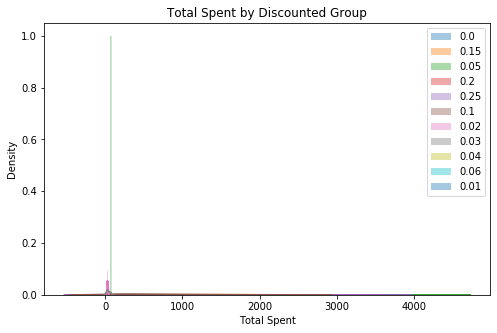

In [32]:
fig, ax=plt.subplots(figsize = (8,5))
for discount_grps, grp_data in discounts.items():
    sns.distplot(grp_data, label=discount_grps, ax=ax )
ax.legend()
ax.set(title ='Total Spent by Discounted Group', ylabel = 'Density');

The discount percentages that do not have enough data are then taken out of the dataset using a for loop to find the small categories. The other discount categories with more than 8 data points are then shown with a p-value < 0.05 Therefore the data is not normal but because the size of the data. The results of the normal test is ignored. Therefore, moving on to test the equal variance using the levene's test. The results are shown below.

In [33]:
for k,v in discounts.items():
    if len(v) > 8: 
        stat,p = stats.normaltest(v)
        print(f"The {k} Normaltest p-value = {round(p,4)}")
    else: 
        print(f"The column {k} is too small.")

The 0.0 Normaltest p-value = 0.0
The 0.15 Normaltest p-value = 0.0
The 0.05 Normaltest p-value = 0.0
The 0.2 Normaltest p-value = 0.0
The 0.25 Normaltest p-value = 0.0
The 0.1 Normaltest p-value = 0.0
The column 0.02 is too small.
The column 0.03 is too small.
The column 0.04 is too small.
The column 0.06 is too small.
The column 0.01 is too small.


In [34]:
toosmall = (0.02, 0.03, 0.04, 0.06, 0.01)
for key in toosmall:
    discounts.pop(key)

In [35]:
for k,v in discounts.items():
    print(f"There are {len(v)} in group {k}")

There are 1298 in group 0.0
There are 152 in group 0.15
There are 182 in group 0.05
There are 159 in group 0.2
There are 148 in group 0.25
There are 170 in group 0.1


In [36]:
data = []
for k,v in discounts.items():
    data.append(v)
data[0]

0        168.00
1         98.00
2        174.00
3        167.40
4       1696.00
5         77.00
10       336.00
13      1088.00
14       200.00
15       604.80
16       640.00
19       168.00
20       304.00
21       486.50
22       380.00
23      1320.00
24       393.00
25       124.80
26       877.50
27        86.40
28       156.00
32        80.00
33        20.80
35       780.00
38       160.00
39       288.00
41       360.00
42        60.80
44       100.80
47       532.00
         ...   
2087    1190.00
2088     136.00
2089     130.00
2090     510.00
2093     420.00
2097     115.80
2100     687.50
2103      52.35
2104     386.40
2105     490.00
2106      86.85
2110     360.00
2114     250.00
2117     152.00
2118     386.00
2119     357.50
2121     210.00
2122      90.00
2131      40.00
2132      22.00
2136      31.00
2138      24.00
2142      18.00
2143      32.00
2145      28.95
2147      14.00
2148      48.00
2151      17.00
2153      31.00
2154      26.00
Name: Total Spent, Lengt

In [37]:
stat,p = stats.levene(*data) 
print(f'Levenes test for equal variance p-value ={round(p,4)} therefore it does not have equal variance.')

Levenes test for equal variance p-value =0.0025 therefore it does not have equal variance.


In [38]:
stat,p = stats.kruskal(*data)
print(f'Kruskal-Wallis t-test p-value ={round(p,4)} therefore the alternative hypothesis is statistically significance.')

Kruskal-Wallis t-test p-value =0.0 therefore the alternative hypothesis is statistically significance.


With multiple different discount percentages a tukey's test is done to see which groups are significantly different between the amount of items sold correlated with at which the discount was given. A matrix table was then created comparing each group with another showing the mean difference.

In [39]:
df_tukeys = prep_data_for_tukeys(discounts)
df_tukeys.head()
df_tukeys.columns = ['Total Spent','Discount']

In [43]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
model= pairwise_tukeyhsd(df_tukeys['Total Spent'],df_tukeys['Discount'])
model.summary()
df = pd.DataFrame(data=model._results_table.data[1:], columns=model._results_table.data[0])
df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.0,0.05,205.7636,0.0010,81.0109,330.5163,True
1,0.0,0.1,58.2625,0.7623,-70.2938,186.8188,False
2,0.0,0.15,90.6617,0.3954,-44.4575,225.7809,False
3,0.0,0.2,87.0942,0.4193,-45.3357,219.5241,False
4,0.0,0.25,139.4796,0.0425,2.7356,276.2235,True
5,0.05,0.1,-147.5011,0.1240,-315.6149,20.6127,False
6,0.05,0.15,-115.1019,0.4068,-288.2860,58.0821,False
7,0.05,0.2,-118.6694,0.3557,-289.7636,52.4247,False
8,0.05,0.25,-66.2841,0.8829,-240.7387,108.1706,False
9,0.1,0.15,32.3992,0.9000,-143.5446,208.3430,False


The only statistically significant discounts are gathered and shown below.

In [44]:
sig = df.loc[df['reject']==True][['group1', 'group2', 'p-adj']]
sig.columns = ['discount1','discount2','p-value']
sig

,discount1,discount2,p-value
0,0.0,0.05,0.0010
4,0.0,0.25,0.0425


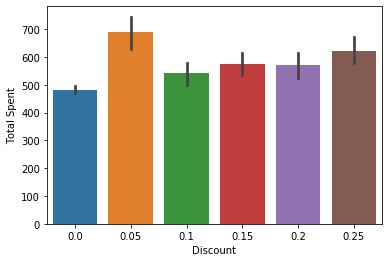

In [45]:
sns.barplot(data=df, x = df_tukeys['Discount'], y= df_tukeys['Total Spent'], ci=68);

As shown in the bar graph and tukeys test above it is statistically significant that the customers spend more money in an order when it is discounted at 5% or 25%. 

# Hypothesis 3

> Does the supplier region have a statistically significant effect on the product quantity sold.

- $H_0$: The supplier region does not have an effect on the product quantity sold.
- $H_A$: THe supplier region does have an effect on the product quantity sold.

Explore the data and pull in the information needed to test the hypothesis. Two data frames were created in order to join the Order table with the OrderDetail table. After gathering the information a bar graph is created to have a general visual of the dataset pulled. 

In [46]:
cur.execute('''SELECT *
               FROM "Order";''')
col_names = [x[0] for x in cur.description]
col_names

['Id',
 'CustomerId',
 'EmployeeId',
 'OrderDate',
 'RequiredDate',
 'ShippedDate',
 'ShipVia',
 'Freight',
 'ShipName',
 'ShipAddress',
 'ShipCity',
 'ShipRegion',
 'ShipPostalCode',
 'ShipCountry']

In [47]:
df_order = pd.DataFrame(cur.fetchall(), columns = col_names)

In [48]:
cur.execute('''SELECT *
               FROM OrderDetail;''')
col_names = [x[0] for x in cur.description]
df_details = pd.DataFrame(cur.fetchall(), columns = col_names)
df_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [49]:
df = pd.merge(df_details,df_order, how='outer',left_on='OrderId', right_on='Id')

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,Id_y,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


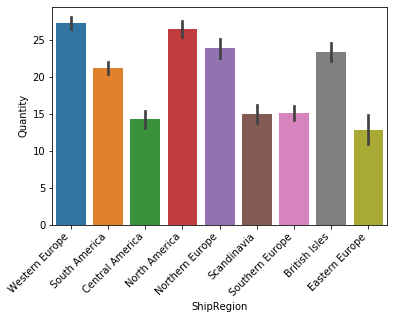

In [51]:
ax = sns.barplot(data=df, x ='ShipRegion', y='Quantity', ci=68)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right');

A regions dictionary is created to store all the data gathered in the two columns. The different ship regions and the quantity amount sold in the order. Then the dictionary is used to create a subplot to view the distribution of the data population.

In [52]:
regions = {}
for region_grps in df['ShipRegion'].unique():
    regions[region_grps]= df.groupby('ShipRegion').get_group(region_grps)['Quantity']
regions

{'Western Europe': 0        12
 1        10
 2         5
 3         9
 4        40
 8         6
 9        15
 10       20
 11       40
 12       25
 13       40
 17       15
 18       21
 19       21
 20       20
 21       35
 22       25
 23       30
 29       50
 30       65
 31        6
 34       16
 35       50
 36       15
 37       21
 43       60
 44       28
 45       60
 46       36
 49       30
        ... 
 2042      2
 2043     30
 2049     30
 2050     30
 2053     10
 2057     20
 2058     15
 2059     18
 2066     10
 2069     35
 2070     20
 2071     25
 2082      3
 2083     21
 2084      4
 2106      9
 2111     40
 2112     20
 2113     30
 2114     20
 2117      8
 2118     40
 2119     22
 2120    130
 2124     10
 2125     30
 2126      2
 2127     20
 2128     20
 2129     10
 Name: Quantity, Length: 745, dtype: int64, 'South America': 5       10
 6       35
 7       15
 14      20
 15      42
 16      40
 24      15
 25      12
 26      25
 27       6
 28      

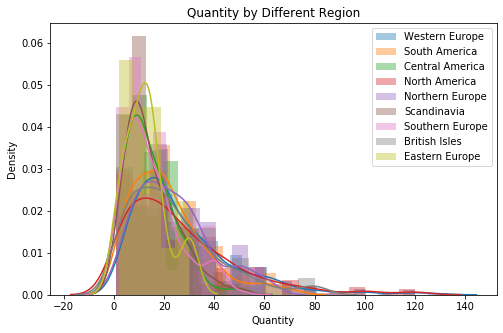

In [53]:
fig, ax=plt.subplots(figsize = (8,5))
for region_grps, grp_data in regions.items():
    sns.distplot(grp_data, label=region_grps, ax=ax)
ax.legend()
ax.set(title ='Quantity by Different Region', ylabel = 'Density');

The idx_outs function is used to find and delete outliers using z-scores. Another subplot graph is then created to see the difference once the outliers found are gone. We can see a slightly more normal distribution in the graph below.

In [54]:
for region_grps, grp_data in regions.items():
    idx_outs = find_outliers_z(grp_data)
    print(f'I found {idx_outs.sum()} outliers in {region_grps} using z-scores')
    regions[region_grps] = grp_data[-idx_outs]

I found 14 outliers in Western Europe using z-scores
I found 5 outliers in South America using z-scores
I found 1 outliers in Central America using z-scores
I found 10 outliers in North America using z-scores
I found 0 outliers in Northern Europe using z-scores
I found 1 outliers in Scandinavia using z-scores
I found 1 outliers in Southern Europe using z-scores
I found 5 outliers in British Isles using z-scores
I found 0 outliers in Eastern Europe using z-scores


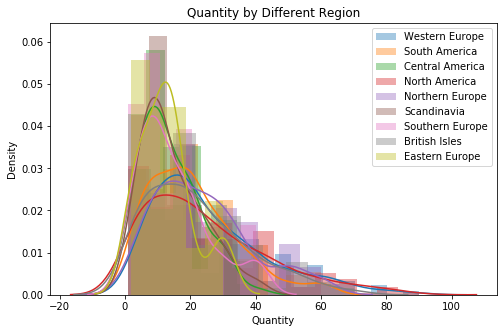

In [55]:
fig, ax=plt.subplots(figsize = (8,5))
for region_grps, grp_data in regions.items():
    sns.distplot(grp_data, label=region_grps, ax=ax)
ax.legend()
ax.set(title ='Quantity by Different Region', ylabel = 'Density');

The p-value of each ship region is gathered and displayed below. All regions except Easter Europe passed the Normaltest p-value <0.05

In [56]:
for k,v in regions.items():
    stat,p = stats.normaltest(v)
    print(f"The {k} Normaltest p-value = {round(p,4)}")

The Western Europe Normaltest p-value = 0.0
The South America Normaltest p-value = 0.0
The Central America Normaltest p-value = 0.0426
The North America Normaltest p-value = 0.0
The Northern Europe Normaltest p-value = 0.0019
The Scandinavia Normaltest p-value = 0.011
The Southern Europe Normaltest p-value = 0.0001
The British Isles Normaltest p-value = 0.0
The Eastern Europe Normaltest p-value = 0.2396


In [57]:
data = []
for k,v in regions.items():
    data.append(v)
data[0]

0       12
1       10
2        5
3        9
4       40
8        6
9       15
10      20
11      40
12      25
13      40
17      15
18      21
19      21
20      20
21      35
22      25
23      30
29      50
30      65
31       6
34      16
35      50
36      15
37      21
43      60
44      28
45      60
46      36
49      30
        ..
2041     5
2042     2
2043    30
2049    30
2050    30
2053    10
2057    20
2058    15
2059    18
2066    10
2069    35
2070    20
2071    25
2082     3
2083    21
2084     4
2106     9
2111    40
2112    20
2113    30
2114    20
2117     8
2118    40
2119    22
2124    10
2125    30
2126     2
2127    20
2128    20
2129    10
Name: Quantity, Length: 731, dtype: int64

In [58]:
stat,p = stats.levene(*data) 
print(f'Levenes test for equal variance p-value ={round(p,4)} therefore it does not have equal variance.')

Levenes test for equal variance p-value =0.0 therefore it does not have equal variance.


In [59]:
stat,p = stats.kruskal(*data)
print(f'Kruskal-Wallis t-test p-value ={round(p,4)} therefore the alternative hypothesis is statistically significance.')

Kruskal-Wallis t-test p-value =0.0 therefore the alternative hypothesis is statistically significance.


With multiple different ship regions a tukey's test is done to see which groups are significantly different between the amount of items sold correlated with which region the order was shipped. A matrix table was then created comparing each group with another showing the mean difference.

In [60]:
df_tukeys = prep_data_for_tukeys(regions)
df_tukeys.head()
df_tukeys.columns = ['ShipRegion','Quantity']

In [63]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
model= pairwise_tukeyhsd(df_tukeys['ShipRegion'],df_tukeys['Quantity'])
model.summary()
df = pd.DataFrame(data=model._results_table.data[1:], columns=model._results_table.data[0])
df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,British Isles,Central America,-8.0298,0.0096,-14.9408,-1.1188,True
1,British Isles,Eastern Europe,-8.9497,0.4395,-21.8496,3.9503,False
2,British Isles,North America,2.7558,0.5634,-1.6172,7.1288,False
3,British Isles,Northern Europe,2.0490,0.9000,-3.4631,7.5612,False
4,British Isles,Scandinavia,-7.3274,0.0313,-14.3104,-0.3444,True
5,British Isles,South America,-1.2707,0.9000,-5.7705,3.2291,False
6,British Isles,Southern Europe,-6.8872,0.0043,-12.4787,-1.2956,True
7,British Isles,Western Europe,3.8876,0.0755,-0.1865,7.9618,False
8,Central America,Eastern Europe,-0.9199,0.9000,-14.6195,12.7797,False
9,Central America,North America,10.7856,0.0010,4.4301,17.1411,True


In [64]:
sig = df.loc[df['reject']==True][['group1', 'group2', 'p-adj']]
sig.columns = ['discount1','discount2','p-value']
sig

,discount1,discount2,p-value
0,British Isles,Central America,0.0096
4,British Isles,Scandinavia,0.0313
6,British Isles,Southern Europe,0.0043
9,Central America,North America,0.0010
10,Central America,Northern Europe,0.0010
12,Central America,South America,0.0314
14,Central America,Western Europe,0.0010
20,Eastern Europe,Western Europe,0.0392
22,North America,Scandinavia,0.0010
23,North America,South America,0.0148


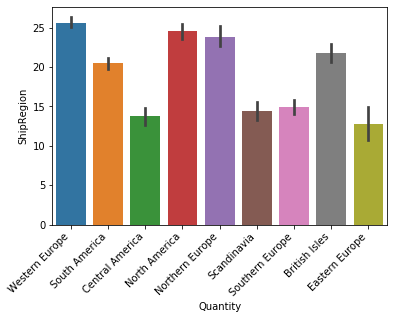

In [62]:
ax = sns.barplot(data=df, x = df_tukeys['Quantity'], y= df_tukeys['ShipRegion'], ci=68)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right');

As shown in the bar graph above it is statistically significant that the customers order more of a product when the supplier region is in Western Europe, North America, and Northern Europe as well as the other regions except Eastern Europe. 

# Hypothesis 4

> Does the supplier region have a statistically significant effect on the total amount spent?

- $H_0$: The supplier region does not have an effect on the total amount spent.
- $H_A$: THe supplier region does have an effect on the total amount spent.

Explore the data and pull in the information needed to test the hypothesis. Another column was created to show the total spent. To find the total amount spent on an order we multiply the unit price by the number of items bought. After gathering the information a bar graph is made to have a general visual of the dataset pulled. 

In [69]:
cur.execute('''SELECT *
               FROM "Order";''')
col_names = [x[0] for x in cur.description]
col_names

['Id',
 'CustomerId',
 'EmployeeId',
 'OrderDate',
 'RequiredDate',
 'ShippedDate',
 'ShipVia',
 'Freight',
 'ShipName',
 'ShipAddress',
 'ShipCity',
 'ShipRegion',
 'ShipPostalCode',
 'ShipCountry']

In [70]:
df_order = pd.DataFrame(cur.fetchall(), columns = col_names)

In [71]:
cur.execute('''SELECT *
               FROM OrderDetail;''')
col_names = [x[0] for x in cur.description]
df_details = pd.DataFrame(cur.fetchall(), columns = col_names)
df_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [72]:
df = pd.merge(df_details,df_order, how='outer',left_on='OrderId', right_on='Id')
df.head()

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,Id_y,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [75]:
df['Total Spent'] = df['UnitPrice'] * df['Quantity']

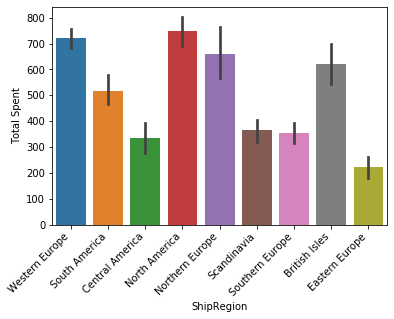

In [74]:
ax = sns.barplot(data=df, x ='ShipRegion', y='Total Spent', ci=68)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right');

A regions dictionary was created to gather all ship regions with the total amount spent in each order to create a subplot to see a general visualization of the data distribution.

In [76]:
regions = {}
for region_grps in df['ShipRegion'].unique():
    regions[region_grps]= df.groupby('ShipRegion').get_group(region_grps)['Total Spent']
regions

{'Western Europe': 0        168.00
 1         98.00
 2        174.00
 3        167.40
 4       1696.00
 8        100.80
 9        234.00
 10       336.00
 11      2592.00
 12        50.00
 13      1088.00
 17        54.00
 18       403.20
 19       168.00
 20       304.00
 21       486.50
 22       380.00
 23      1320.00
 29       760.00
 30      1105.00
 31       153.60
 34       123.20
 35       780.00
 36       591.00
 37       252.00
 43       834.00
 44       100.80
 45      1242.00
 46       288.00
 49       936.00
          ...   
 2042      14.00
 2043     645.00
 2049     570.00
 2050    1317.00
 2053     210.00
 2057     760.00
 2058     480.00
 2059     324.00
 2066      45.00
 2069    2187.50
 2070     640.00
 2071     831.25
 2082      30.00
 2083     714.00
 2084     114.00
 2106      86.85
 2111     720.00
 2112     380.00
 2113     523.50
 2114     250.00
 2117     152.00
 2118     386.00
 2119     357.50
 2120    4322.50
 2124     190.00
 2125     360.00
 2126      36

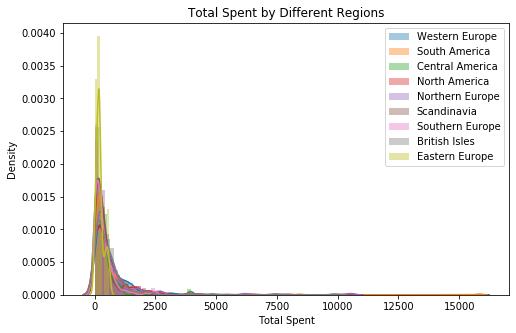

In [77]:
fig, ax=plt.subplots(figsize = (8,5))
for region_grps, grp_data in regions.items():
    sns.distplot(grp_data, label=region_grps, ax=ax)
ax.legend()
ax.set(title ='Total Spent by Different Regions', ylabel = 'Density');

The idx_outs function is used to find and delete outliers using z-scores. Another subplot graph is then created to see the difference once the outliers found are gone. We can see a slightly more normal distribution in the graph below.

In [78]:
for region_grps, grp_data in regions.items():
    idx_outs = find_outliers_z(grp_data)
    print(f'I found {idx_outs.sum()} outliers in {region_grps} using z-scores')
    regions[region_grps] = grp_data[-idx_outs]

I found 11 outliers in Western Europe using z-scores
I found 2 outliers in South America using z-scores
I found 1 outliers in Central America using z-scores
I found 8 outliers in North America using z-scores
I found 2 outliers in Northern Europe using z-scores
I found 1 outliers in Scandinavia using z-scores
I found 3 outliers in Southern Europe using z-scores
I found 4 outliers in British Isles using z-scores
I found 0 outliers in Eastern Europe using z-scores


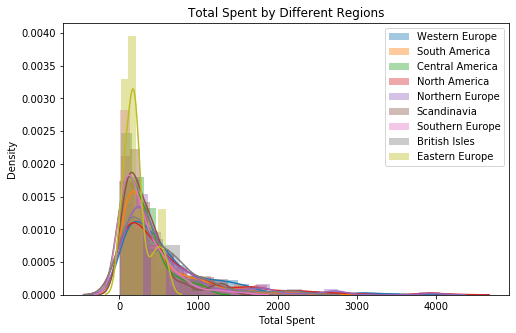

In [79]:
fig, ax=plt.subplots(figsize = (8,5))
for region_grps, grp_data in regions.items():
    sns.distplot(grp_data, label=region_grps, ax=ax)
ax.legend()
ax.set(title ='Total Spent by Different Regions', ylabel = 'Density');

In [80]:
for k,v in regions.items():
    stat,p = stats.normaltest(v)
    print(f"The {k} Normaltest p-value = {round(p,4)}")

The Western Europe Normaltest p-value = 0.0
The South America Normaltest p-value = 0.0
The Central America Normaltest p-value = 0.0
The North America Normaltest p-value = 0.0
The Northern Europe Normaltest p-value = 0.0
The Scandinavia Normaltest p-value = 0.0
The Southern Europe Normaltest p-value = 0.0
The British Isles Normaltest p-value = 0.0
The Eastern Europe Normaltest p-value = 0.1024


The p-value of each ship region is gathered and displayed below. All regions except Easter Europe passed the Normaltest p-value <0.05

In [81]:
data = []
for k,v in regions.items():
    data.append(v)
data[0]

0        168.00
1         98.00
2        174.00
3        167.40
4       1696.00
8        100.80
9        234.00
10       336.00
11      2592.00
12        50.00
13      1088.00
17        54.00
18       403.20
19       168.00
20       304.00
21       486.50
22       380.00
23      1320.00
29       760.00
30      1105.00
31       153.60
34       123.20
35       780.00
36       591.00
37       252.00
43       834.00
44       100.80
45      1242.00
46       288.00
49       936.00
         ...   
2041      92.00
2042      14.00
2043     645.00
2049     570.00
2050    1317.00
2053     210.00
2057     760.00
2058     480.00
2059     324.00
2066      45.00
2069    2187.50
2070     640.00
2071     831.25
2082      30.00
2083     714.00
2084     114.00
2106      86.85
2111     720.00
2112     380.00
2113     523.50
2114     250.00
2117     152.00
2118     386.00
2119     357.50
2124     190.00
2125     360.00
2126      36.00
2127     500.00
2128     465.00
2129      92.00
Name: Total Spent, Lengt

In [82]:
stat,p = stats.levene(*data) 
print(f'Levenes test for equal variance p-value ={round(p,4)} therefore it does not have equal variance.')

Levenes test for equal variance p-value =0.0 therefore it does not have equal variance.


In [83]:
stat,p = stats.kruskal(*data)
print(f'Kruskal-Wallis t-test p-value ={round(p,4)} therefore the alternative hypothesis is statistically significance.')

Kruskal-Wallis t-test p-value =0.0 therefore the alternative hypothesis is statistically significance.


With multiple different ship regions a tukey's test is done to see which groups are significantly different between the amount of money spent correlated with which region the order was shipped. A matrix table was then created comparing each group with another showing the mean difference.

In [84]:
df_tukeys = prep_data_for_tukeys(regions)
df_tukeys.head()
df_tukeys.columns = ['ShipRegion','Total Spent']

In [87]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
model= pairwise_tukeyhsd(df_tukeys['ShipRegion'],df_tukeys['Total Spent'])
model.summary()
df = pd.DataFrame(data=model._results_table.data[1:], columns=model._results_table.data[0])
df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,British Isles,Central America,-209.6348,0.1729,-456.6540,37.3843,False
1,British Isles,Eastern Europe,-272.2816,0.6387,-733.6086,189.0454,False
2,British Isles,North America,127.0945,0.2184,-28.9196,283.1086,False
3,British Isles,Northern Europe,57.1591,0.9000,-140.5640,254.8822,False
4,British Isles,Scandinavia,-153.8169,0.5896,-403.4135,95.7797,False
5,British Isles,South America,-40.7325,0.9000,-201.1679,119.7029,False
6,British Isles,Southern Europe,-183.0726,0.1065,-383.7118,17.5666,False
7,British Isles,Western Europe,133.5464,0.1011,-11.8117,278.9044,False
8,Central America,Eastern Europe,-62.6468,0.9000,-552.6739,427.3803,False
9,Central America,North America,336.7293,0.0010,109.4754,563.9833,True


In [88]:
sig = df.loc[df['reject']==True][['group1', 'group2', 'p-adj']]
sig.columns = ['discount1','discount2','p-value']
sig

,discount1,discount2,p-value
9,Central America,North America,0.0010
10,Central America,Northern Europe,0.0359
14,Central America,Western Europe,0.0010
22,North America,Scandinavia,0.0048
23,North America,South America,0.0016
24,North America,Southern Europe,0.0010
28,Northern Europe,Southern Europe,0.0144
32,Scandinavia,Western Europe,0.0021
34,South America,Western Europe,0.0010
35,Southern Europe,Western Europe,0.0010


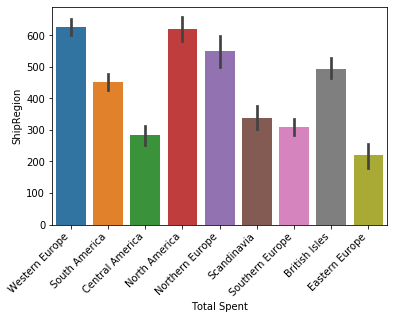

In [86]:
ax = sns.barplot(data=df, x = df_tukeys['Total Spent'], y= df_tukeys['ShipRegion'], ci=68)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right');

As shown in the bar graph above it is statistically significant that the customers spend more money in an order when the supplier region is in Western Europe, North America, and Northern Europe as well as the other regions except Eastern Europe. 

# Conlusion

In conclusion, discounting items at 5%, 15%, 20%, and 25% are statistically significant in increasing the quantity of products sold in an order with a p-value of 0.001. To increase the amount spent in an order the only discounts that are statistically significant are at 5% and 25%. The region at where the products are shipped has a statistical significance in the amount of products sold as well as the amount of money spent in all of the regions except Eastern Europe. Eastern Europe has p-value at 0.1024 which does not pass the tukey's test.

# Recommendations 

1. Discount products at 5% to increase number of products sold.
2. Increase supplier regions in Western Europe, North America and Northern Europe.
3. Increase marketing efforts in Eastern Europe.